## Loading Data

Here, we want to load our PDF files in Markdown file format. 

In [5]:
# Get started with parsing PDF files: 
import nest_asyncio
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

nest_asyncio.apply()

openai_api_key = os.getenv("OPENAI_API_KEY")
llama_cloud_api_key = os.getenv("LLAMA_CLOUD_API_KEY")

In [6]:
from llama_parse import LlamaParse

In [7]:
# Instructions to Parser
parsingInstruction1 = """The provided document is a lecture slide for a course on introductory programming and computer science. 
Convert the provided document content into Markdown format. 

Note that there are embedded figures, bullet points, code snippets, flowcharts, etc. 

Infer what each page is trying convey and summarize the contents.


If you encounter a flowchart or an image, give a summary or explanation of it while also extracting text and structure of it. If possible, also related to the concept being conveyed or discussed.  

Also, try to extract the structure, hierarchy, and formatting of the contents where texts exist.
"""

withInstructionParsing = LlamaParse(
                                result_type="markdown", 
                                parsing_instruction=parsingInstruction1,
                                gpt4o_mode=True
                            )

In [22]:
# List all pdf files in a directory
import glob
lec_slides = glob.glob("GSU - CIS 3260 - Fall 2023/Lecture_Slides/*.pdf")  # Adjust the path to your directory containing CSV files

In [27]:
import re

In [28]:
def extract_week_number(file_path):
    match = re.search(r"Week (\d+)", file_path)
    return int(match.group(1)) if match else None

# Sort files based on the week number
sorted_files = sorted(lec_slides, key=extract_week_number)


In [26]:
import pickle

Load data using LlamaParse

In [30]:
for pdf_file in sorted_files[:6]:
    # Generate a unique name for each .pkl file based on the PDF file name
    pkl_filename = os.path.basename(pdf_file).replace('.pdf', '.pkl')
    pkl_filepath = os.path.join("GSU - CIS 3260 - Fall 2023/Lecture_Slides", pkl_filename)

    # Load and parse the data
    document = withInstructionParsing.load_data(pdf_file) 
    # Save the parsed document to a .pkl file
    with open(pkl_filepath, 'wb') as f:
        pickle.dump(document, f)
    print(f"Saved parsed document to {pkl_filepath}")

Started parsing the file under job_id 8166ba59-ca25-408a-b77f-0c4d6ab472c6
Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 1.pkl
Started parsing the file under job_id da608c15-8e9b-4720-b7f6-f5a88d5a7661
Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 2.pkl
Started parsing the file under job_id 49ae9319-dbae-488b-8553-1558fb3155f6
Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 3.pkl
Started parsing the file under job_id 9baccfae-3ecc-477b-bcd3-cb6033eaf7b6
Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 4.pkl
Started parsing the file under job_id b4b4be2b-3562-4c98-8e3c-93087044d3c4
Saved parsed document to GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 5.pkl
Error while parsing the file 'GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 7.pdf': Failed to parse the file: {"detail":"You've exceeded the maximum number of pages you can parse in a day (1000). Please contact support to increase you

Note: 
* Parsing first five weeks lecture first. Error due to daily limit for using LlamaParse.
* Missing week 6 lec slides

Parse once for each file. Load pickle files when we have to access documents. 

In [31]:
md_lec_slides = glob.glob("GSU - CIS 3260 - Fall 2023/Lecture_Slides/*.pkl") 

In [32]:
md_lec_slides

['GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 5.pkl',
 'GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 1.pkl',
 'GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 3.pkl',
 'GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 2.pkl',
 'GSU - CIS 3260 - Fall 2023/Lecture_Slides/Week 4.pkl']

In [137]:
# List to store loaded documents
documents = []

# Loop through file numbers 1 through 8
for i in md_lec_slides:  # 9 is exclusive, so it goes from 1 to 8
    doc = pickle.load(open(i, "rb"))
    documents.append(doc)

In [138]:
# Load Syllabus 
doc1 = pickle.load(open("GSU - CIS 3260 - Fall 2023/Syllabus/demo.pkl", "rb"))
documents.append(doc1)

In [139]:
documents

[[Document(id_='0e62d532-1453-4d3d-ab42-1f341bcdc6c6', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='# Objectives for class 5\n\n## --- Chapter 3 ---\n\n### 3.5 To implement selection control with nested if and multi-way if-elif-else statements (§3.6).\n\n### 3.6 To combine conditions using logical operators (and, or, and not) (§3.10).\n\n### 3.7 To use selection statements with combined conditions (§§3.11–3.12).\n\n### 3.8 To understand how to develop a program with selections.\n\n---\n\n**Review Assignment 1 and Assignment 2**\n\n**Review Quiz 1**\n---\n# Multiple-way Decisions: select one block of many to execute (No ELSE)\n\n```python\nif <condition 1> :\n    <statement>\n    <statement>\n    <statement>\nelif <condition 2> :\n    <statement>\n    <statement>\n<Next line of code>\n```\n\n## Flowchart Explanation\n\n- **Condition 1** is evaluated first.\n  - If **True**, the **If block** is executed.\n  - If **Fa

## Documents to Nodes (Chunking)

### Method 1: MarkdownFileParser

In [40]:
from llama_index.core.node_parser import MarkdownElementNodeParser
from llama_index.llms.openai import OpenAI

node_parser = MarkdownElementNodeParser(
    llm=OpenAI(model="gpt-4o"), num_workers=8
)

In [120]:
nodes = []
base_nodes = []
objects = []

for doc in documents:
    pdoc = node_parser.get_nodes_from_documents(doc)
    nodes.append(pdoc)
    base, obj = node_parser.get_nodes_and_objects(pdoc)
    base_nodes.append(base)
    objects.append(obj)

4it [00:00, 22399.49it/s]
  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 27060.03it/s]
100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
4it [00:00, 65027.97it/s]
100%|██████████| 4/4 [00:01<00:00,  3.36it/s]
4it [00:00, 55553.70it/s]
100%|██████████| 4/4 [00:01<00:00,  2.44it/s]
6it [00:00, 59213.70it/s]
100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


In [121]:
print(base_nodes[3][3])

Node ID: 9ba94805-7a70-4426-a2fc-60424205e6c5
Text: ---  Python Variable Name Rules  - Must start with a letter or
underscore `_` - Must consist of letters, numbers, and underscores -
Case Sensitive - Cannot be a **reserved word**   Examples:  **Good:**
- `spam` - `eggs` - `spam23` - `_speed`  **Bad:** - `23spam` - `#sign`
- `var.12`  **Different:** - `spam` - `Spam` - `SPAM` ---  Reserved
Words ...


In [76]:
objects[3][2].get_content()

'This table lists mathematical operators and their corresponding operations.,\nwith the following columns:\n- Operator: None\n- Operation: None\n'

In [94]:
objects[3][2].relationships["3"].metadata['table_df']

"{' Operator ': {0: ' +        ', 1: ' -        ', 2: ' *        ', 3: ' /        ', 4: ' **       ', 5: ' %        '}, ' Operation     ': {0: ' Addition      ', 1: ' Subtraction   ', 2: ' Multiplication', 3: ' Division      ', 4: ' Power         ', 5: ' Remainder     '}}"

In [91]:
objects[3][2].relationships["3"].metadata['table_summary']

'This table lists mathematical operators and their corresponding operations.,\nwith the following columns:\n- Operator: None\n- Operation: None\n'

### Method 2: Semantic Chunking 

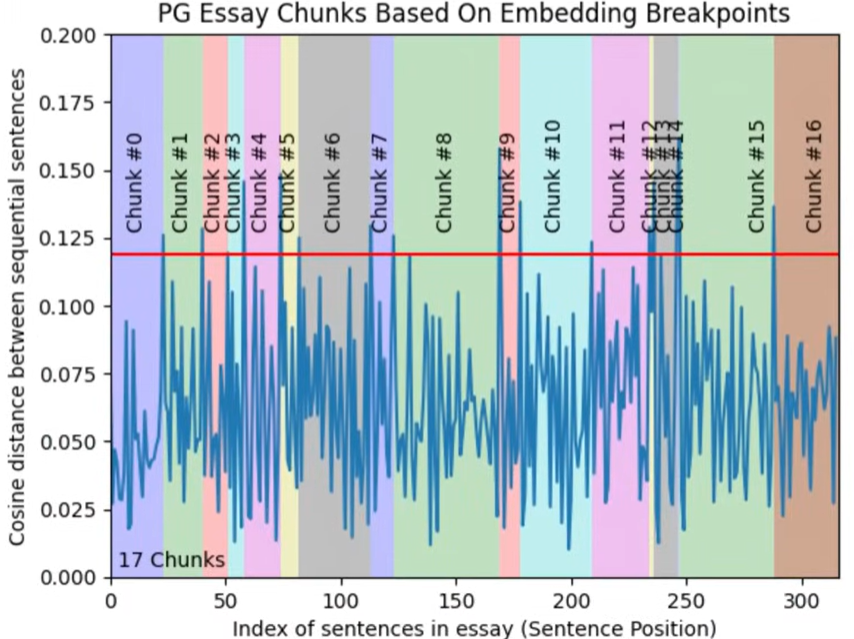

ref: https://www.youtube.com/watch?v=8OJC21T2SL4&t=1933s

In [122]:
from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)

from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding()

# Semantic splitter
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=embed_model
)

In [123]:
nodes_semantic = []

for doc in documents:
    pdoc = node_parser.get_nodes_from_documents(doc)
    nodes_semantic.append(pdoc)

4it [00:00, 73584.28it/s]
100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 23301.69it/s]
100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
4it [00:00, 53261.00it/s]
100%|██████████| 4/4 [00:01<00:00,  3.30it/s]
4it [00:00, 76608.29it/s]
100%|██████████| 4/4 [00:01<00:00,  2.53it/s]
6it [00:00, 78154.73it/s]
100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


In [50]:
nodes_semantic

[[TextNode(id_='3f9f8509-94c0-4b23-b39a-682495db2065', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='0e62d532-1453-4d3d-ab42-1f341bcdc6c6', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='7772a31da1634729a0a824aef7030481d8b7fd01a10bfdd2b1af581c4ae06de9'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='bf6b418d-a220-4e56-93b8-573c94954336', node_type=<ObjectType.INDEX: '3'>, metadata={'col_schema': 'Column: Condition 1\nType: Boolean\nSummary: None\n\nColumn: Condition 2\nType: Boolean\nSummary: None\n\nColumn: Action\nType: String\nSummary: None'}, hash='a34f649908ec160b08916ad0ada3dde43023666a1304e2287cc09f600bc72a8c')}, text='Objectives for class 5\n\n --- Chapter 3 ---\n\n 3.5 To implement selection control with nested if and multi-way if-elif-else statements (§3.6).\n\n 3.6 To combine conditions using logical operators (and, or, and not) (§3.10).\n

In [57]:
print(nodes_semantic[2][2].get_content())

This table lists various assignment operators in programming, providing their names, examples, and equivalent expressions.,
with the following columns:
- Operator: None
- Name: None
- Example: None
- Equivalent: None

| Operator | Name                        | Example  | Equivalent  |
|---|---|---|---|
| `+=`     | Addition assignment         | `i += 8` | `i = i + 8` |
| `-=`     | Subtraction assignment      | `i -= 8` | `i = i - 8` |
| `*=`     | Multiplication assignment   | `i *= 8` | `i = i * 8` |
| `/=`     | Float division assignment   | `i /= 8` | `i = i / 8` |
| `//=`    | Integer division assignment | `i //= 8`| `i = i // 8`|
| `%=`     | Remainder assignment        | `i %= 8` | `i = i % 8` |
| `**=`    | Exponent assignment         | `i **= 8`| `i = i ** 8`|



## Store & Retrieval

We use recursive retriever

In [124]:
import itertools

base_nodes_mdp = list(itertools.chain(*base_nodes))
objects_mdp = list(itertools.chain(*objects))


In [125]:
len(objects_mdp)

20

### 1. For MarkdownParsed Chunks

In [126]:
from llama_index.core import VectorStoreIndex

# Index and store our chunks using VectorStoreIndex
recursive_index = VectorStoreIndex(nodes=base_nodes_mdp + objects_mdp)

# Set up query enginge
recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=5, verbose=True)

In [127]:
res = recursive_query_engine.query(
    "who is the instructor for the course"
)

Retrieval entering fa6d6387-62fb-4d63-81cd-7fecedd3a203: TextNode
Retrieving from object TextNode with query who is the instructor for the course


In [128]:
print(res)

Dr. Yuan Long


In [129]:
res = recursive_query_engine.query(
    "what did we learn in lecture 3"
)

Retrieval entering 13a3e729-38f3-471b-a560-80d5565a0dec: TextNode
Retrieving from object TextNode with query what did we learn in lecture 3


In [130]:
print(res)

In lecture 3, we learned about writing Boolean expressions using relational operators, generating random numbers using specific functions, programming with Boolean expressions, implementing selection control using one-way if statements, and implementing selection control using two-way if-else statements.


In lecture 3, we learned about writing Boolean expressions using relational operators, generating random numbers using specific functions, programming with Boolean expressions, implementing selection control using one-way if statements, and implementing selection control using two-way if-else statements.

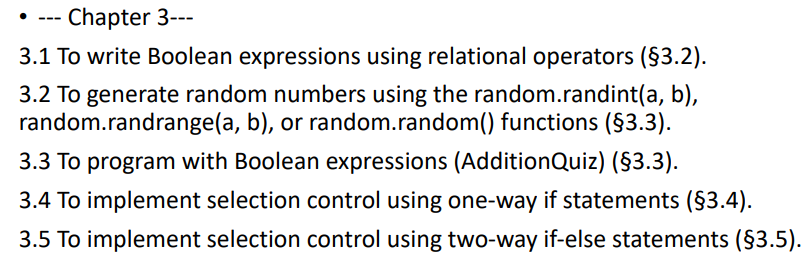

## Evaluation Metrics

Currently based on faithfulness

In [131]:
from llama_index.core.evaluation import FaithfulnessEvaluator

In [132]:
# create llm
llm = OpenAI(model="gpt-4", temperature=0.0)

# define evaluator
evaluator = FaithfulnessEvaluator(llm=llm)

In [133]:
eval_result = evaluator.evaluate_response(response=res)

In [134]:
print(str(eval_result.passing)) # binary pass/fail
print(str(eval_result.score)) # numerical score
print(str(eval_result.feedback)) # string 


True
1.0
YES
